# LSTM Models for Time Series Forecasting (Tutorial)

This notebook follows a tutorial for LSTM deep learning models for time series forecasting using Tensorflow. The article is available here:

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

It is a surpringly in-depth tutorial. This will be long and take a long time. We will explore:

* Univariate LSTM models
    * Data Preparation
    * Vanilla LSTM
    * Stacked LSTM
    * Bidirectional LSTM
    * CNN LSTM
    * ConvLSTM
* Multivariate LSTM models
    * Multiple input series
    * Multiple parallel series
* Multi-Step LSTM models
    * Data Preparation
    * Vector output model
    * Encoder-Decoder model
* Multivariate Multi-Step models
    * Multiple input multi-step output
    * Multiple parallel input and multi-step output
    
Let's get started!

## Univariate LSTM Models

"Univariate" because it is a series of single values, such as a single asset price.

### Data Preparation

The LSTM model will take a sequence of past observations as input and ouput a predicted future value. When we have one series ("Univariate"), we need to chop that series into rolling windows of size **n**, with **n-1** "past" observations as the **X** value and **1** "future" observation as the **y** value. The following function does just that!

In [8]:
# function that splits sequences
import numpy as np

def split_sequence(sequence, n_steps):
    # initialize empty list
    X, y = list(), list()
    
    # iterate through the sequence
    for i in range(len(sequence)):
        # find the end of the rolling window
        end_ix = i + n_steps
        
        # check if we went too far
        if end_ix > len(sequence)-1:
            break
        
        # gather the "past" observations
        seq_X = sequence[i:end_ix]
        
        # get the "future" observation
        seq_y = sequence[end_ix]
        
        # append
        X.append(seq_X)
        y.append(seq_y)
        
    # return X and y as arrays
    return np.array(X), np.array(y)

In [9]:
## Test the split_sequence function
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
n_steps = 3

X, y = split_sequence(raw_seq, n_steps)
for i in range(len(y)):
    print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


Let's bring in some real data, to keep this interesting. How about...the price of Tesla stock from 2018-02-26 to 2021-02-23? Sounds good.

In [390]:
import pandas as pd
url = "https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=1519430400&period2=1614124800&interval=1d&events=history&includeAdjustedClose=true"
tesla_df = pd.read_csv(url)
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
tesla_df = tesla_df.set_index('Date')

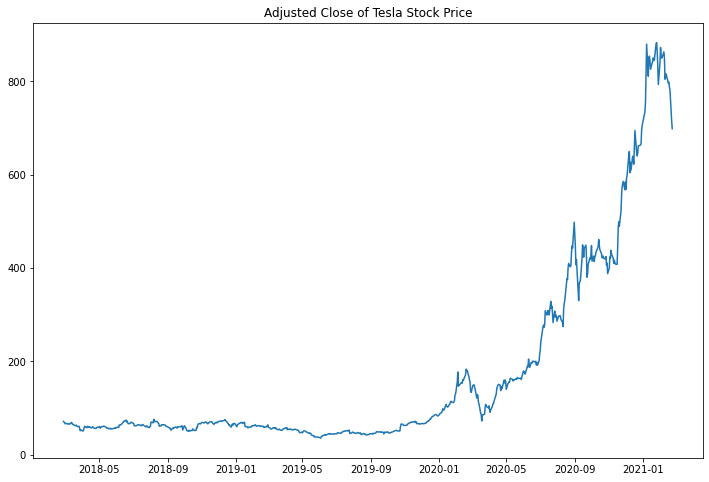

In [377]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(tesla_df.index, tesla_df['Adj Close'])
plt.title("Adjusted Close of Tesla Stock Price");

In [392]:
tesla_aclose = tesla_df['Adj Close']
list_tesla_aclose = list(tesla_aclose)
n_steps = 5
X, y = split_sequence(list_tesla_aclose, 5)

for i in range(10):
    print("Past: ", X[i], "\t Future: ", y[i])

Past:  [71.484001 70.197998 68.612    66.185997 67.024002] 	 Future:  66.669998
Past:  [70.197998 68.612    66.185997 67.024002 66.669998] 	 Future:  65.639999
Past:  [68.612    66.185997 67.024002 66.669998 65.639999] 	 Future:  66.459999
Past:  [66.185997 67.024002 66.669998 65.639999 66.459999] 	 Future:  65.82
Past:  [67.024002 66.669998 65.639999 66.459999 65.82    ] 	 Future:  65.433998
Past:  [66.669998 65.639999 66.459999 65.82     65.433998] 	 Future:  69.101997
Past:  [65.639999 66.459999 65.82     65.433998 69.101997] 	 Future:  68.367996
Past:  [66.459999 65.82     65.433998 69.101997 68.367996] 	 Future:  65.325996
Past:  [65.82     65.433998 69.101997 68.367996 65.325996] 	 Future:  65.120003
Past:  [65.433998 69.101997 68.367996 65.325996 65.120003] 	 Future:  64.269997


In [379]:
## split X and y into train and test sets
n_features = 1
X = X.reshape(X.shape[0], X.shape[1], n_features)

X_train = X[:-150]
y_train = y[:-150]

X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(599, 5, 1) (599,)
(150, 5, 1) (150,)


### Vanilla LSTM

This is the simplest LSTM model, with a single LSTM layer. At its simplest, it has an LSTM layer as the input layer and then a Dense output layer and that's it. One node in the output layer, because this is a univariate series.

The **input_shape** is very important. In this case, we have a single feature; the past observations. This single feature will have **n_steps** observations in it. Therefore, the input shape in this model should be **(n_steps, n_features = 1)**.

In [14]:
import tensorflow as tf

In [15]:
# how many features are there? just 1. The past observations
n_features = 1

# construct the model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation = 'relu', input_shape = (n_steps, n_features)),
    tf.keras.layers.Dense(1)
])

# compile the model
model.compile(optimizer = 'adam', loss='mse')

The **X** feature vector will be expected to have shape **[samples, time_steps, n_features]**, so it must be reshaped. Actually, we just need to add the **n_features** dimension.

In [16]:
## train the model
history = model.fit(X_train, y_train, epochs=200, verbose=False, validation_data=(X_test, y_test))

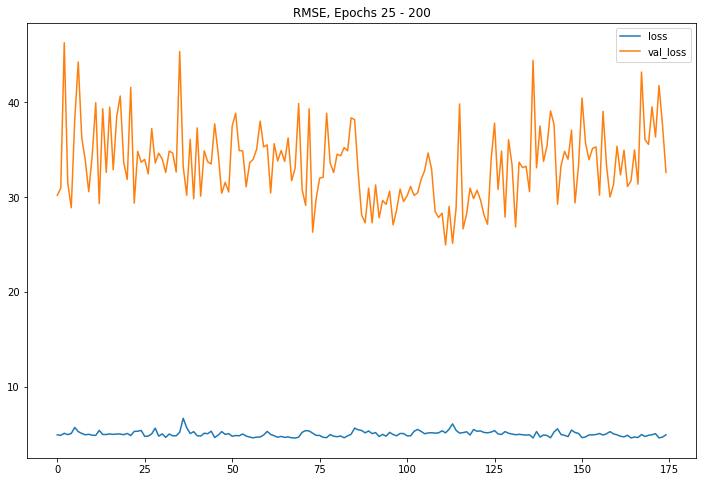

In [17]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss'][25:]), label='loss')
plt.plot(np.sqrt(history.history['val_loss'][25:]), label='val_loss')
plt.title("RMSE, Epochs 25 - 200")
plt.legend();

We can see that the Vanilla LSTM model does a pretty nice job of overfitting the training data, but does not do so well on the test data. At least we know that the model is working! This simple model might actually do pretty well if we bring in some regularization. Let's see the predicted price of Tesla stock on February 24th. Then we can check it online!

In [18]:
next_val = [X[-1][i].item() for i in range(1,5)]
next_val.append(y[-1])
next_val = np.array(next_val)
next_val = next_val.reshape(1, n_steps, n_features)

In [19]:
# get next prediction
model.predict(next_val)

array([[660.3183]], dtype=float32)

### Stacked LSTM

This model has multiple LSTM layers that feed into one another. 

However, this creates a potential hazard; an LSTM layer requires a 3-dimensional input, but by default generates a 2-dimensional output. To have an LSTM layer lead into another, we must use the **return_sequences=True** parameter in the first layer. Then, it will create the 3-dimensional output the next LSTM layer needs.

Our data is still chopped into sequences. No need to pre-process again.

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [21]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, validation_data=(X_test, y_test))


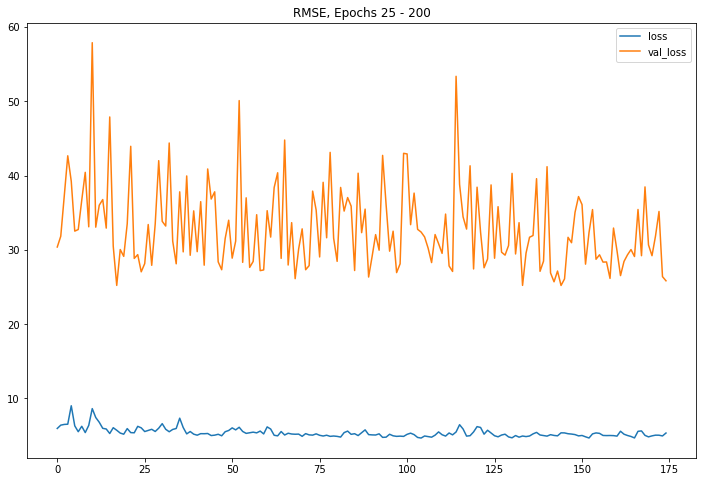

In [22]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss'][25:]), label='loss')
plt.plot(np.sqrt(history.history['val_loss'][25:]), label='val_loss')
plt.title("RMSE, Epochs 25 - 200")
plt.legend();

In [23]:
next_val = [X[-1][i].item() for i in range(1,5)]
next_val.append(y[-1])
next_val = np.array(next_val)
next_val = next_val.reshape(1, n_steps, n_features)

# get next prediction, actual value 742.02
model.predict(next_val)

array([[736.601]], dtype=float32)

### Bidirectional LSTM

This type of LSTM model learns the sequence both forward and backward, then combines those interpretations. It is actually two LSTM models; one that sees the sequences in the usual order and one that sees the sequences reversed. Thus, the Bidirectional LSTM model sees more *context* in the sequences and can sometimes learn the patterns better.

Luckily this is super easy to do in Tensorflow.

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), 
                                  input_shape = (n_steps, n_features)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss = 'mse')

In [25]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, 
                    validation_data=(X_test, y_test))

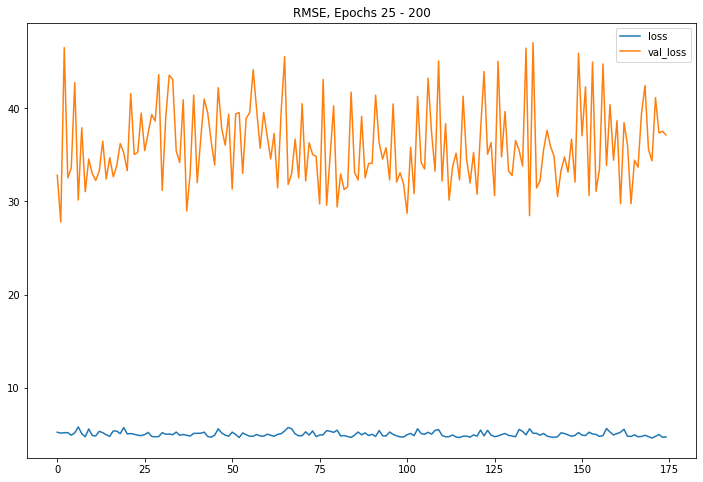

In [26]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss'][25:]), label='loss')
plt.plot(np.sqrt(history.history['val_loss'][25:]), label='val_loss')
plt.title("RMSE, Epochs 25 - 200")
plt.legend();

In [27]:
next_val = [X[-1][i].item() for i in range(1,5)]
next_val.append(y[-1])
next_val = np.array(next_val)
next_val = next_val.reshape(1, n_steps, n_features)

# get next prediction, actual value 742.02
model.predict(next_val)

array([[699.57916]], dtype=float32)

### CNN LSTM

Convolutional Neural Networks (CNN) are typically used for image classification. They really excel when *nearby* data is *related*...like in a picture. CNNs are really great at extracting important features from data, so they are often used in autoencoders as well.

In univariate, sequential time-series modelling, CNN layers can interpret subsequences in the data. That's the role CNNs play in the hybrid CNN-LSTM model; the CNN layer analyzes subsequences, the LSTM layer performs the same Long-Short-Term-Memory analysis as before.

BUT! This changes the shape required by the model. We need to split the sequences into **sub-sequences** with the same number of **timesteps**...It will be easiest to show it. The CNN-LSTM requires:

`[samples, subsequences, timesteps, features]`

In [28]:
# choose steps for split_sequences
n_steps = 6
# split series in sequences
X, y = split_sequence(tesla_aclose, n_steps)

# get the data into the correct shape
n_features = 1
n_subseq = 3
n_timesteps = 2
X = X.reshape((X.shape[0], n_subseq, n_timesteps, n_features))

In [29]:
X.shape

(748, 3, 2, 1)

In [30]:
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(598, 3, 2, 1) (598,)
(150, 3, 2, 1) (150,)


But wait, there's more. We need to make sure we use the same CNN model for reading each separate sub-sequence. To do this, we have to wrap the CNN layer in a TimeDistributed layer, which applies the entire model once per input sequence.

The number of filters in the convolutional layer represent the number of reads, or interpretations, of the input sequence. The kernel size of the convolution layer represents the number of timesteps included in each read.

This layer is followed by a MaxPooling layer (pretty usual with CNNs) that ensures the model keeps only the most "important" features.

Then, the whole thing must be Flattened (standard stuff again) into a one-dimensional vector that can be fed to the LSTM layer.

All of those CNN-based layers need to be wrapped in TimeDistributed layers. This will be the deepest neural network so far.

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, 
                                                           kernel_size=1,
                                                           activation='relu'),
                                   input_shape=(None, n_timesteps, n_features)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [32]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, 
                    validation_data=(X_test, y_test))

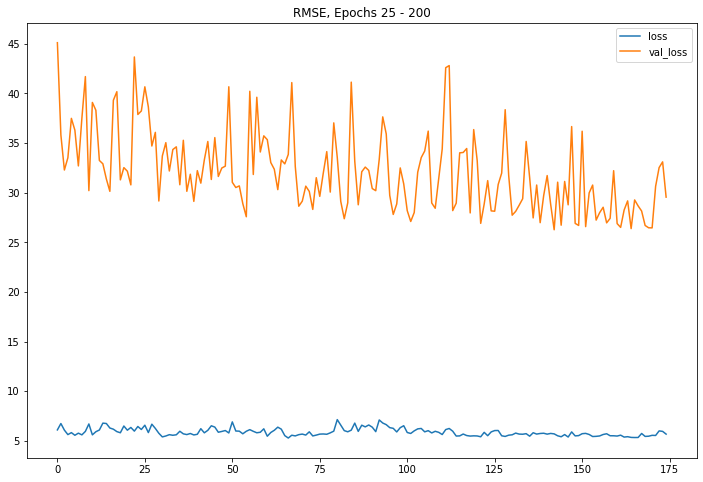

In [33]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss'][25:]), label='loss')
plt.plot(np.sqrt(history.history['val_loss'][25:]), label='val_loss')
plt.title("RMSE, Epochs 25 - 200")
plt.legend();

In [34]:
X[-1][1][1].item()

787.380005

In [35]:
X[-1][2][0].item()

781.299988

In [36]:
X[-1][2][1].item()

714.5

In [37]:
X[-1][0][1].item()

796.219971

In [38]:
next_val = [X[-1][0][1].item()]
next_val.append(X[-1][1][0].item())
next_val.append(X[-1][1][1].item())
next_val.append(X[-1][2][0].item())
next_val.append(X[-1][2][1].item())
next_val.append(y[-1].item())

In [39]:
next_val = np.array(next_val)
next_val = next_val.reshape((1, n_subseq, n_timesteps, n_features))

In [40]:
model.predict(tf.convert_to_tensor(next_val))

array([[720.2492]], dtype=float32)

In [132]:
pred = model.predict(X_test)

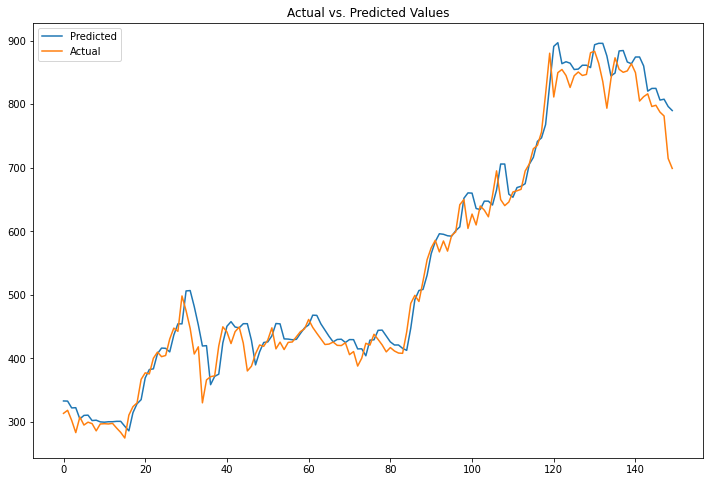

In [134]:
plt.figure(figsize=(12,8))
plt.plot(pred, label='Predicted')
plt.plot(y_test, label='Actual')
plt.title('Actual vs. Predicted Values')
plt.legend();

### ConvLSTM

This model is related to the CNN-LSTM. However, in this case the convolutional stuff is built directly into the LSTM layer. Thus, we will need even more dimensions. The ConvLSTM expects input data in the shape:

`[samples, timesteps, rows, columns, features]`

We will split each sample into sub-sequences, then timesteps will be the number of steps in each sub-sequence, and columns will be the number of sub-sequences per sequence. Rows will be 1, because this is still univariate.

In [141]:
# split into sequences of length 6
n_steps = 4
X, y = split_sequence(tesla_aclose, n_steps)

# reshape into [samples, timesteps, rows, columns ,features]
n_features = 1
n_timesteps = 2
n_rows = 1
n_cols = 2
X = X.reshape((X.shape[0], n_timesteps, n_rows, n_cols, n_features))

In [143]:
# training and test sets
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(600, 2, 1, 2, 1) (600,)
(150, 2, 1, 2, 1) (150,)


In [144]:
# build the model

model = tf.keras.models.Sequential([
    tf.keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_timesteps, n_rows, n_cols, n_features)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [145]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, 
                    validation_data=(X_test, y_test))

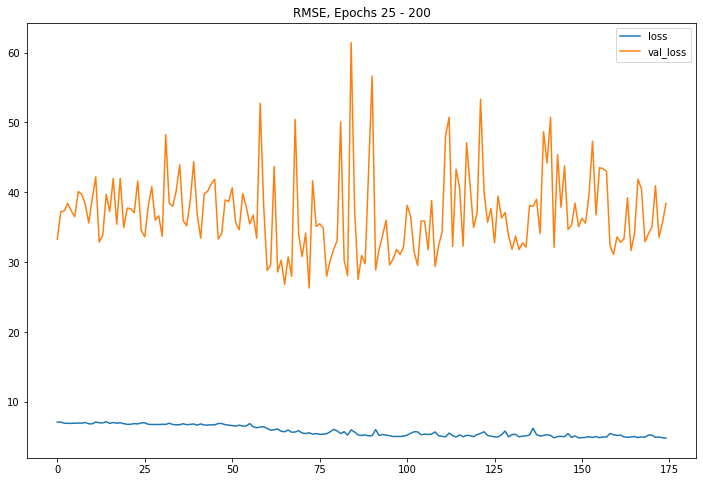

In [146]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss'][25:]), label='loss')
plt.plot(np.sqrt(history.history['val_loss'][25:]), label='val_loss')
plt.title("RMSE, Epochs 25 - 200")
plt.legend();

In [162]:
next_val = np.append(X[-1].reshape(4,), y[-1].item())[1:].reshape((1, n_timesteps, n_rows, n_cols, n_features))
model.predict(next_val)

array([[670.09906]], dtype=float32)

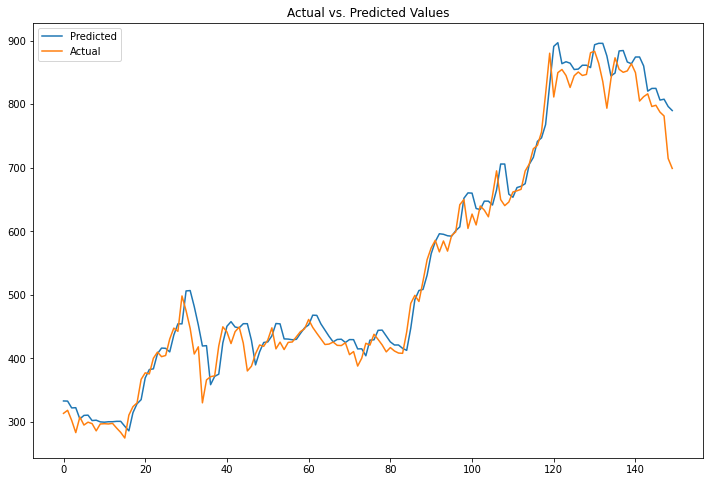

In [163]:
plt.figure(figsize=(12,8))
plt.plot(pred, label='Predicted')
plt.plot(y_test, label='Actual')
plt.title('Actual vs. Predicted Values')
plt.legend();

### Use the BEST one (so far)

The best one so far, judging by the RMSE on the validation set, is the CNN-LSTM. Let's recreate it and check the correlation of the model with the actual values.

In [194]:
# choose steps for split_sequences
n_steps = 6
# split series in sequences
X, y = split_sequence(tesla_aclose, n_steps)

# get the data into the correct shape
n_features = 1
n_subseq = 3
n_timesteps = 2
X = X.reshape((X.shape[0], n_subseq, n_timesteps, n_features))

In [195]:
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(598, 3, 2, 1) (598,)
(150, 3, 2, 1) (150,)


In [196]:
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, 
                                                           kernel_size=1,
                                                           activation='relu'),
                                   input_shape=(None, n_timesteps, n_features)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [197]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, 
                    validation_data=(X_test, y_test))

In [199]:
pred = model.predict(X_test)

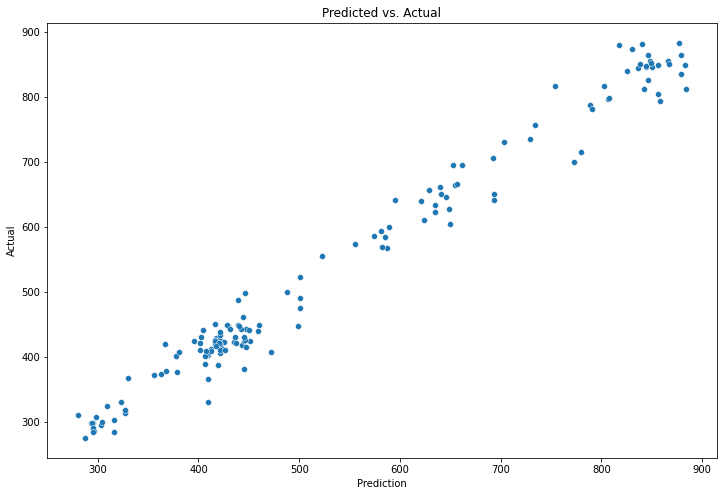

In [207]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.scatterplot(x=pred.reshape(150,), y=y_test)
plt.title('Predicted vs. Actual')
plt.xlabel('Prediction')
plt.ylabel('Actual');

In [210]:
cor = np.corrcoef(pred.reshape(150,), y_test)[0,1]
print('The correlation coefficient between predicted values and actual values is: ', round(cor, 4))

The correlation coefficient between predicted values and actual values is:  0.9899


This really high correlation between predicted values and actual values is great news! It means that this model is good at guessing the direction of the movement, even though it may not be as good at guessing the magnitude of moves.

## Multivariate LSTM Models

A multivariate series has multiple variables at each timestep. Qui aurait cru.

There are two main types of multivariate models...

1. Multiple Input Series - these models have more than one input and an output that depends on the inputs. The inputs are parallel because they each have a value, or observation, at each timestep. The target to be predicted (y) is the output series, while the input series are the independent variables.

2. Multiple Parallel Series - in this type of model, we have multiple input series to act as the independent variables and want to predict the future value of multiple time series.



### Multiple Input Series

We will keep the price of Tesla stock as our target series. But we need other time series to act as inputs! Let's think of two time series that we think will have some relationship with Tesla stock price...how about SPY, which tracks the S&P 500 (and thereby general market conditions), Toyota's adjusted closing price (a proxy to the state of the automobile market), and...the US regular conventional gas price. High or volatile gas prices out to be related to sale of fuel-efficient vehicles like Teslas, right? Let's pull in all that data.

In [354]:
tesla_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
749,2021-02-17,779.090027,799.840027,762.010010,798.150024,798.150024,25996500
750,2021-02-18,780.900024,794.690002,776.270020,787.380005,787.380005,17897000
751,2021-02-19,795.000000,796.789978,777.369995,781.299988,781.299988,18904800
752,2021-02-22,762.640015,768.500000,710.200012,714.500000,714.500000,37011700
753,2021-02-23,662.130005,713.609985,619.000000,698.840027,698.840027,66397000


In [370]:
toyota_url = "https://query1.finance.yahoo.com/v7/finance/download/TM?period1=1456531200&period2=1614384000&interval=1d&events=history&includeAdjustedClose=true"
toyota_df = pd.read_csv(toyota_url)

In [371]:
toyota_df["Date"] = pd.to_datetime(toyota_df['Date'])
toyota_df = toyota_df.set_index('Date')


In [375]:
toyota_aclose = toyota_df.loc["2018-02-26":"2021-02-23", "Adj Close"]
toyota_aclose

Date
2018-02-26    138.429993
2018-02-27    136.029999
2018-02-28    134.600006
2018-03-01    130.389999
2018-03-02    130.589996
                 ...    
2021-02-17    156.529999
2021-02-18    153.449997
2021-02-19    153.550003
2021-02-22    152.440002
2021-02-23    152.729996
Name: Adj Close, Length: 754, dtype: float64

In [382]:
spy_url = "https://query1.finance.yahoo.com/v7/finance/download/SPY?period1=1456531200&period2=1614384000&interval=1d&events=history&includeAdjustedClose=true"
spy_df = pd.read_csv(spy_url)
spy_df['Date'] = pd.to_datetime(spy_df['Date'])
spy_df = spy_df.set_index('Date')
spy_aclose = spy_df.loc["2018-02-26":"2021-02-23", 'Adj Close']

In [383]:
spy_aclose

Date
2018-02-26    262.744843
2018-02-27    259.464050
2018-02-28    256.835663
2018-03-01    253.101089
2018-03-02    254.405853
                 ...    
2021-02-17    392.390015
2021-02-18    390.720001
2021-02-19    390.029999
2021-02-22    387.029999
2021-02-23    387.500000
Name: Adj Close, Length: 754, dtype: float64

In [403]:
gasreg_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GASREGCOVW&scale=left&cosd=2016-02-02&coed=2021-02-22&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-02-27&revision_date=2021-02-27&nd=1990-08-20"
gasreg_df = pd.read_csv(gasreg_url)

In [404]:
gasreg_df['DATE'] = pd.to_datetime(gasreg_df['DATE'])
gasreg_df = gasreg_df.set_index('DATE')
gasreg_series = gasreg_df['2018-02-26':'2021-02-23']
gasreg_series

,GASREGCOVW
DATE,
2018-02-26,2.442
2018-03-05,2.462
2018-03-12,2.455
2018-03-19,2.494
2018-03-26,2.541
...,...
2021-01-25,2.298
2021-02-01,2.316
2021-02-08,2.372


In [414]:
# merge the series into a DataFrame
series_df = pd.DataFrame({'tesla':tesla_aclose, 'toyota':toyota_aclose, 'spy':spy_aclose})
series_df = series_df.join(gasreg_series)

# can't have all those nan values in there
series_df = series_df.fillna(method='ffill')
series_df

,tesla,toyota,spy,GASREGCOVW
Date,,,,
2018-02-26,71.484001,138.429993,262.744843,2.442
2018-02-27,70.197998,136.029999,259.464050,2.442
2018-02-28,68.612000,134.600006,256.835663,2.442
2018-03-01,66.185997,130.389999,253.101089,2.442
2018-03-02,67.024002,130.589996,254.405853,2.442
...,...,...,...,...
2021-02-17,798.150024,156.529999,392.390015,2.372
2021-02-18,787.380005,153.449997,390.720001,2.372
2021-02-19,781.299988,153.550003,390.029999,2.372


In [426]:
## We don't want the bigger numbers, like SPY, to overpower the smaller numbers.
## We will normalize these numbers by taking the cumulative sum of the daily percent change.
## Since this only relies on the current observation and previous observations, it does not introduce look-ahead bias!
normed_series_df = np.cumsum(series_df.pct_change())
normed_series_df

,tesla,toyota,spy,GASREGCOVW
Date,,,,
2018-02-26,NaN,NaN,NaN,NaN
2018-02-27,-0.017990,-0.017337,-0.012487,0.000000
2018-02-28,-0.040583,-0.027850,-0.022617,0.000000
2018-03-01,-0.075942,-0.059127,-0.037157,0.000000
2018-03-02,-0.063280,-0.057594,-0.032002,0.000000
...,...,...,...,...
2021-02-17,3.119184,0.192787,0.478149,0.000843
2021-02-18,3.105691,0.173110,0.473893,0.000843
2021-02-19,3.097969,0.173762,0.472127,0.000843


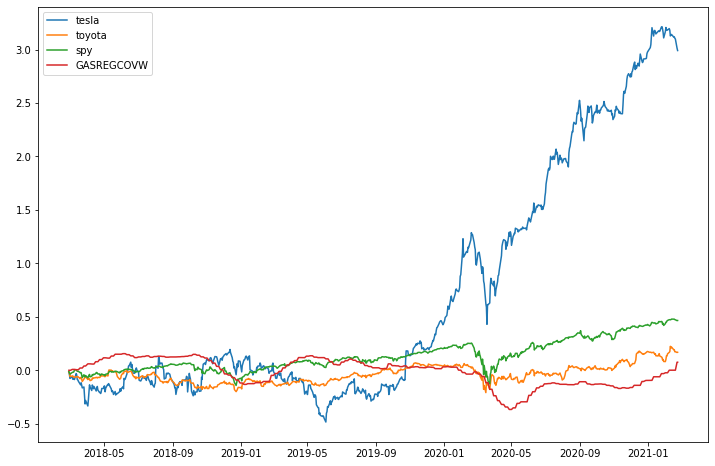

In [427]:
## Now let's plot the series all together, for fun
plt.figure(figsize = (12,8))
for col in normed_series_df.columns:
    plt.plot(normed_series_df[col], label=col)
plt.legend();

In [430]:
# Can't have the nan in there
normed_series_df.dropna(inplace=True)
normed_series_df

,tesla,toyota,spy,GASREGCOVW
Date,,,,
2018-02-27,-0.017990,-0.017337,-0.012487,0.000000
2018-02-28,-0.040583,-0.027850,-0.022617,0.000000
2018-03-01,-0.075942,-0.059127,-0.037157,0.000000
2018-03-02,-0.063280,-0.057594,-0.032002,0.000000
2018-03-05,-0.068562,-0.054607,-0.020444,0.008190
...,...,...,...,...
2021-02-17,3.119184,0.192787,0.478149,0.000843
2021-02-18,3.105691,0.173110,0.473893,0.000843
2021-02-19,3.097969,0.173762,0.472127,0.000843


Now we've got the data, but we need to slice it into sequences like before.

In [454]:
def split_sequences(sequences, n_steps, target):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix >= len(sequences):
            break
        seq_x = sequences.iloc[i:end_ix,:]
        seq_y = sequences.iloc[end_ix, :][target]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [455]:
X, y = split_sequences(normed_series_df, n_steps=4, target='tesla')

In [466]:
print("Example observation: ")
print()
print("Input: \n", X[0])
print()
print("Output: \n", y[0])

Example observation: 

Input: 
 [[-0.01799008 -0.01733724 -0.01248661  0.        ]
 [-0.04058329 -0.02784958 -0.02261667  0.        ]
 [-0.07594158 -0.05912749 -0.03715739  0.        ]
 [-0.06328022 -0.05759365 -0.03200228  0.        ]]

Output: 
 -0.06856196562648176


In [474]:
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(599, 4, 4) (599,)
(150, 4, 4) (150,)


Now that the data has been appropriately sliced, any of the LSTM methods from the Univariate section can be used! Let's make a very basic one.

In [477]:
# we have 4 timesteps of 4 features in the input data
n_steps = 4
n_features = 4


model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape = (n_steps, n_features)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [484]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, validation_data=(X_test, y_test))


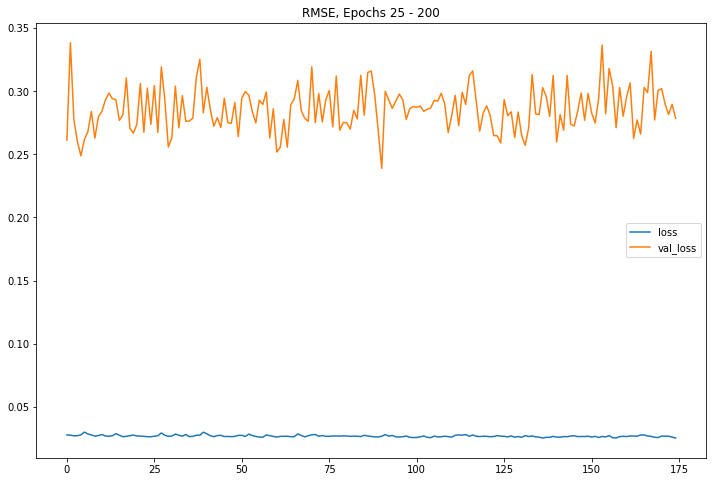

In [485]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss'][25:]), label='loss')
plt.plot(np.sqrt(history.history['val_loss'][25:]), label='val_loss')
plt.title("RMSE, Epochs 25 - 200")
plt.legend();

In [489]:
pred = model.predict(X_test)

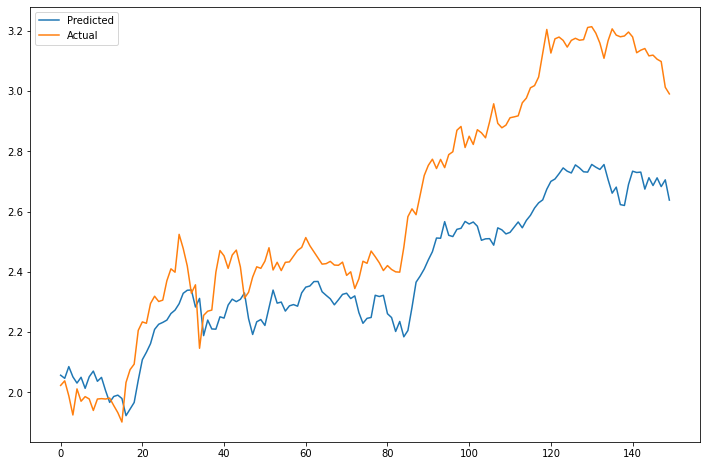

In [495]:
plt.figure(figsize=(12,8))
plt.plot(pred, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend();

### Deeper model with Mutiple Input Series

I just want to try more than a vanilla LSTM model. Let's do a CNN-LSTM model.

In [544]:
# get the data into the correct shape
n_features = 4
n_subseq = 2
n_timesteps = 2
X = X.reshape((X.shape[0], 1, n_subseq, n_timesteps, n_features))

In [545]:
X[0]

array([[[[-0.01799008, -0.01733724, -0.01248661,  0.        ],
         [-0.04058329, -0.02784958, -0.02261667,  0.        ]],

        [[-0.07594158, -0.05912749, -0.03715739,  0.        ],
         [-0.06328022, -0.05759365, -0.03200228,  0.        ]]]])

In [546]:
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(599, 1, 2, 2, 4) (599,)
(150, 1, 2, 2, 4) (150,)


In [547]:
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64,
                                                          kernel_size=1,
                                                          activation='relu'),
                                   input_shape = (None, n_subseq, n_timesteps, n_features)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [548]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, 
                    validation_data=(X_test, y_test))

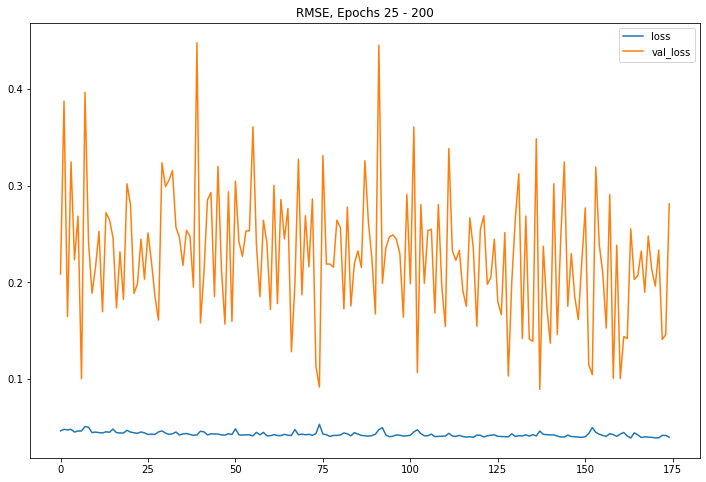

In [549]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss'][25:]), label='loss')
plt.plot(np.sqrt(history.history['val_loss'][25:]), label='val_loss')
plt.title("RMSE, Epochs 25 - 200")
plt.legend();

In [550]:
pred = model.predict(X_test)

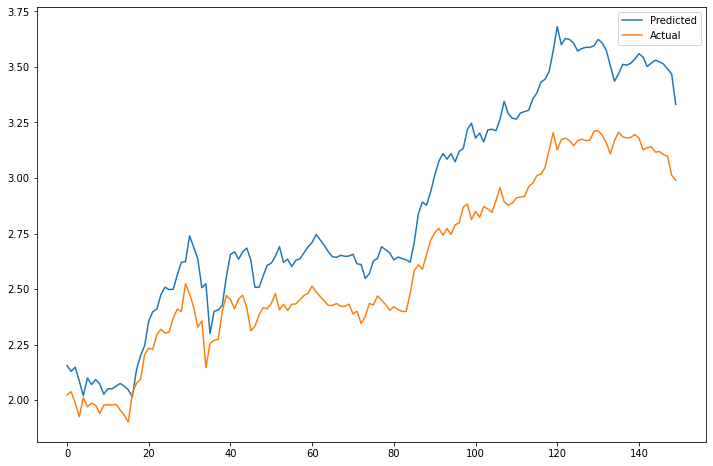

In [551]:
plt.figure(figsize=(12,8))
plt.plot(pred, label='Predicted')
plt.plot(y_test, label='Actual')
plt.legend();

In [553]:
series_df.shape

(754, 4)

In [562]:
price_array = np.array(series_df.iloc[-150:, :]['tesla'])
pred = pred.reshape(150,)

In [589]:
pred_price = pred[1:] - pred[:-1].copy()
pred_price = pred_price*price_array[:-1]

In [591]:
pred_price = pred_price + price_array[:-1]

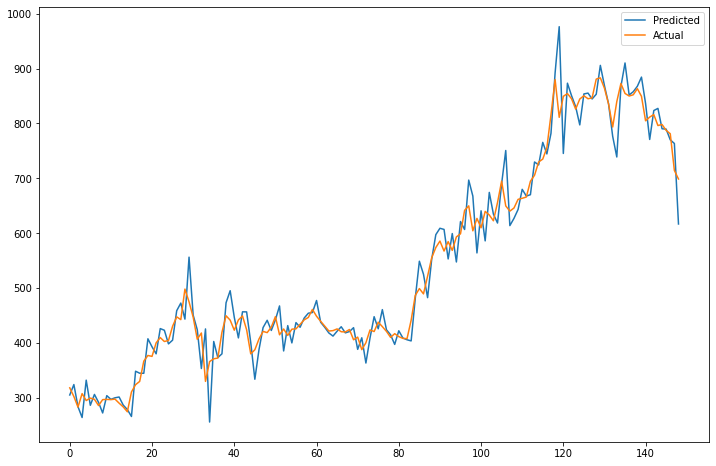

In [607]:
plt.figure(figsize=(12,8))
plt.plot(pred_price, label='Predicted')
plt.plot(price_array[1:], label='Actual')
plt.legend();

### Multiple Parallel Series

In this case, we have multiple input series and we want to forecast multiple output series. The biggest change between this one and the last will be how the input and ouput sequences are sliced. Then, we just need to set the right number of filters in the output layer.

In [620]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    
    for i in range(len(sequences)):
        end_ix = i + n_steps
        
        if end_ix > len(sequences)-1:
            break
        
        seq_X = sequences[i:end_ix, :]
        seq_y = sequences[end_ix, :]
        
        X.append(seq_X)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [621]:
X, y = split_sequences(np.array(series_df), 4)

In [623]:
X[0]

array([[ 71.484001, 138.429993, 262.744843,   2.442   ],
       [ 70.197998, 136.029999, 259.46405 ,   2.442   ],
       [ 68.612   , 134.600006, 256.835663,   2.442   ],
       [ 66.185997, 130.389999, 253.101089,   2.442   ]])

In [624]:
y[0]

array([ 67.024002, 130.589996, 254.405853,   2.442   ])

This time, let's try the model without rescaling. Then we will try it with rescaling and compare.

In [625]:
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(600, 4, 4) (600, 4)
(150, 4, 4) (150, 4)


In [637]:
# our X slices have 4 timesteps each
n_steps = 4
# we have 4 time series
n_features = 4

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape = (n_steps, n_features)),
    tf.keras.layers.LSTM(100, activation='relu'),
    
    # Only change: We now want 4 outputs
    tf.keras.layers.Dense(n_features)
])

model.compile(optimizer='adam', loss='mse')

In [638]:
history = model.fit(X_train, y_train, epochs=500, verbose=False,
                    validation_data = (X_test, y_test))

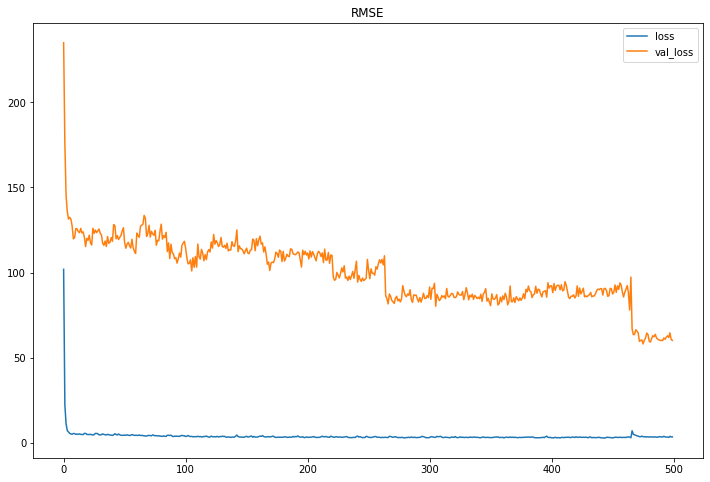

In [639]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss']), label='loss')
plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
plt.title("RMSE")
plt.legend();

The model fits the training data pretty well, but doesn't really get anywhere with the validation data...

Let's make some predictions and see how they track.

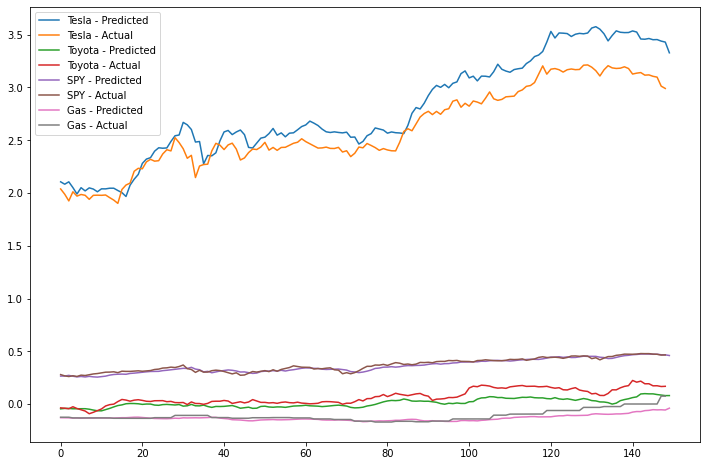

In [704]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(pred[:,0], label='Tesla - Predicted')
plt.plot(y_test[1:,0], label='Tesla - Actual')
plt.plot(pred[:,1], label='Toyota - Predicted')
plt.plot(y_test[1:,1], label='Toyota - Actual')
plt.plot(pred[:,2], label='SPY - Predicted')
plt.plot(y_test[1:,2], label='SPY - Actual')
plt.plot(pred[:,3], label='Gas - Predicted')
plt.plot(y_test[1:,3], label='Gas - Actual')
plt.legend();

As we can see, the predictions are not so great in this model. This might be because the scale of Tesla relative to Gas changes significantly. Let's try rescaling the data.

In [651]:
X, y = split_sequences(np.array(normed_series_df), n_steps=4)

print('Sample data')
print("Input: \n", X[0])
print()
print("Output: \n", y[0])


Sample data
Input: 
 [[-0.01799008 -0.01733724 -0.01248661  0.        ]
 [-0.04058329 -0.02784958 -0.02261667  0.        ]
 [-0.07594158 -0.05912749 -0.03715739  0.        ]
 [-0.06328022 -0.05759365 -0.03200228  0.        ]]

Output: 
 [-0.06856197 -0.0546072  -0.02044449  0.00819001]


In [652]:
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(599, 4, 4) (599, 4)
(150, 4, 4) (150, 4)


In [653]:
# our X slices have 4 timesteps each
n_steps = 4
# we have 4 time series
n_features = 4

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape = (n_steps, n_features)),
    tf.keras.layers.LSTM(100, activation='relu'),
    
    # Only change: We now want 4 outputs
    tf.keras.layers.Dense(n_features)
])

model.compile(optimizer='adam', loss='mse')

In [658]:
history = model.fit(X_train, y_train, epochs=500, verbose=False,
                    validation_data = (X_test, y_test))

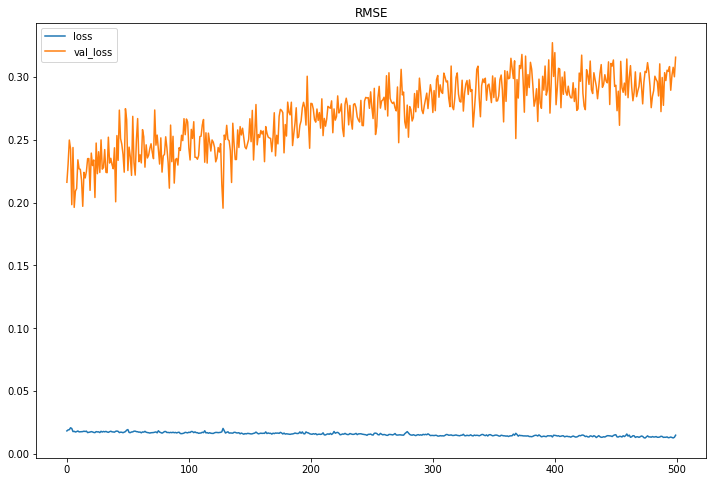

In [659]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss']), label='loss')
plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
plt.title("RMSE")
plt.legend();

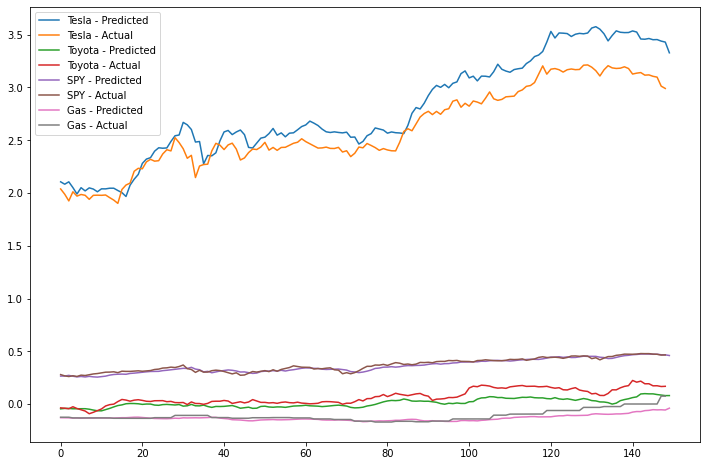

In [705]:
pred = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(pred[:,0], label='Tesla - Predicted')
plt.plot(y_test[1:,0], label='Tesla - Actual')
plt.plot(pred[:,1], label='Toyota - Predicted')
plt.plot(y_test[1:,1], label='Toyota - Actual')
plt.plot(pred[:,2], label='SPY - Predicted')
plt.plot(y_test[1:,2], label='SPY - Actual')
plt.plot(pred[:,3], label='Gas - Predicted')
plt.plot(y_test[1:,3], label='Gas - Actual')
plt.legend();

In the scaled form, all of the predictions seem pretty off. Let's translate those back into prices and see if it looks any better!

In [669]:
price_array = np.array(series_df.iloc[-150:, :])
pred = pred.reshape(150,4)

In [670]:
pred_price = pred[1:,:] - pred[:-1,:].copy()
pred_price = pred_price*price_array[:-1,:]

In [671]:
pred_price = pred_price + price_array[:-1]

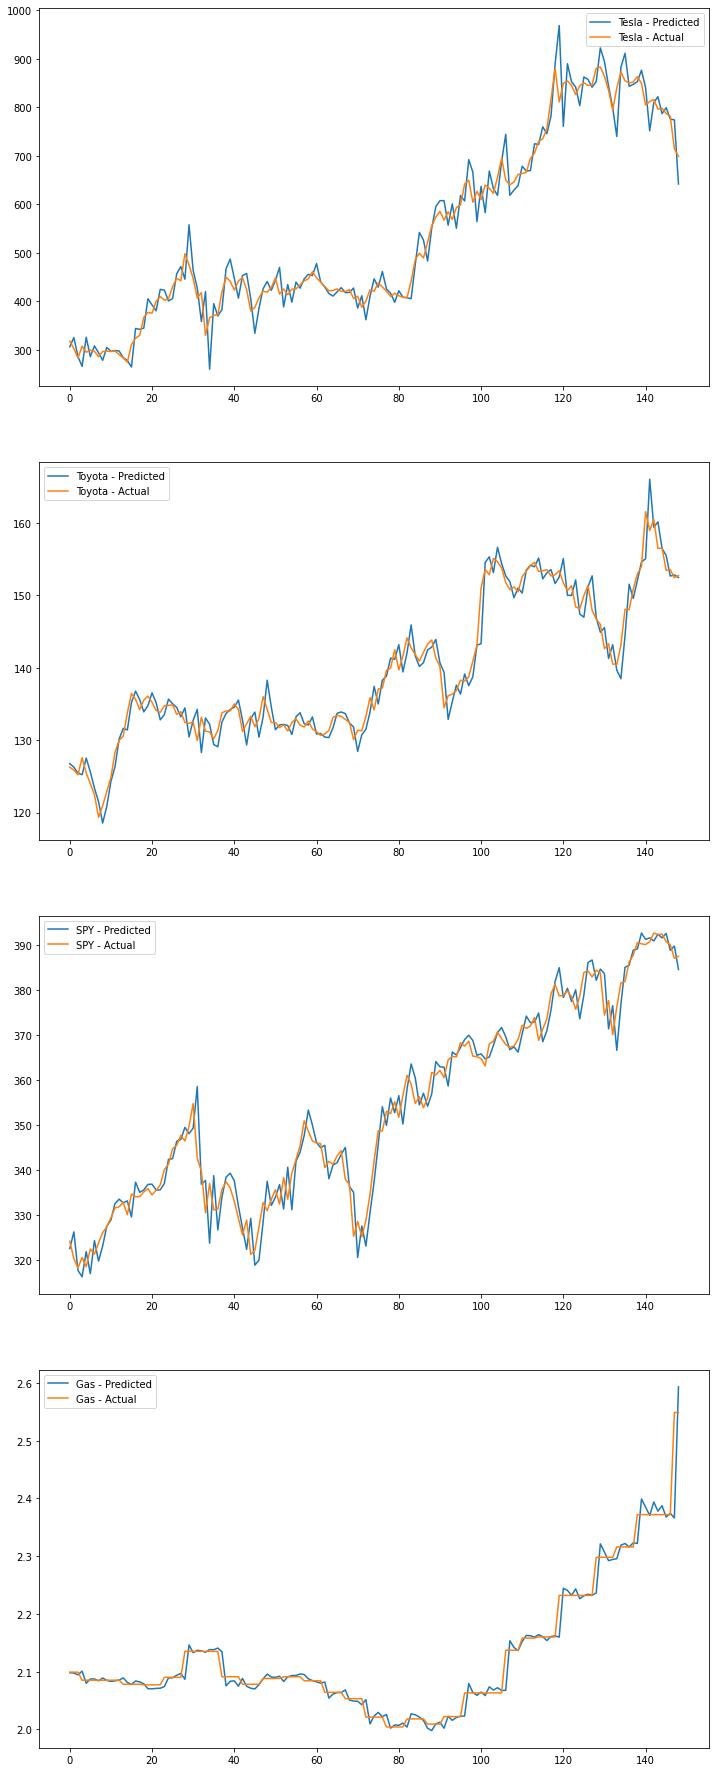

In [703]:
plt.figure(figsize=(12,32))

plt.subplot(4,1,1)
plt.plot(pred_price[:,0], label='Tesla - Predicted')
plt.plot(price_array[1:,0], label='Tesla - Actual')
plt.legend()

plt.subplot(4,1,2)
plt.plot(pred_price[:,1], label='Toyota - Predicted')
plt.plot(price_array[1:,1], label='Toyota - Actual')
plt.legend()

plt.subplot(4,1,3)
plt.plot(pred_price[:,2], label='SPY - Predicted')
plt.plot(price_array[1:,2], label='SPY - Actual')
plt.legend()

plt.subplot(4,1,4)
plt.plot(pred_price[:,3], label='Gas - Predicted')
plt.plot(price_array[1:,3], label='Gas - Actual')
plt.legend();

These predictions are ***SO. MUCH. BETTER***.

Now, let's try a deeper CNN-LSTM with a parallel output.

In [682]:
n_subseq = 2
n_timesteps = 2
n_features = 4

X = X.reshape((X.shape[0], 1, n_subseq, n_timesteps, n_features))

In [683]:
X_train = X[:-150]
y_train = y[:-150]
X_test = X[-150:]
y_test = y[-150:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(599, 1, 2, 2, 4) (599, 4)
(150, 1, 2, 2, 4) (150, 4)


In [684]:
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64,
                                                          kernel_size=1,
                                                          activation='relu'),
                                   input_shape = (None, n_subseq, n_timesteps, n_features)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.compile(optimizer='adam', loss='mse')

In [685]:
history = model.fit(X_train, y_train, epochs=200, verbose=False, 
                    validation_data=(X_test, y_test))

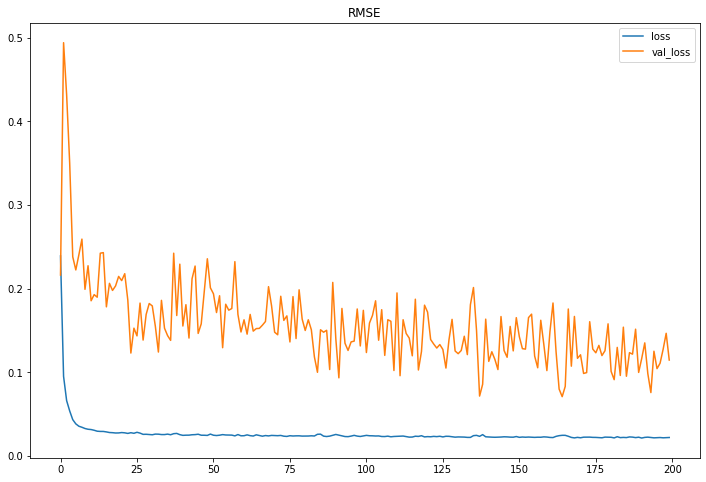

In [686]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss']), label='loss')
plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
plt.title("RMSE")
plt.legend();

Hey! That's looking pretty good. Let's check some predictions.

In [687]:
pred = model.predict(X_test)

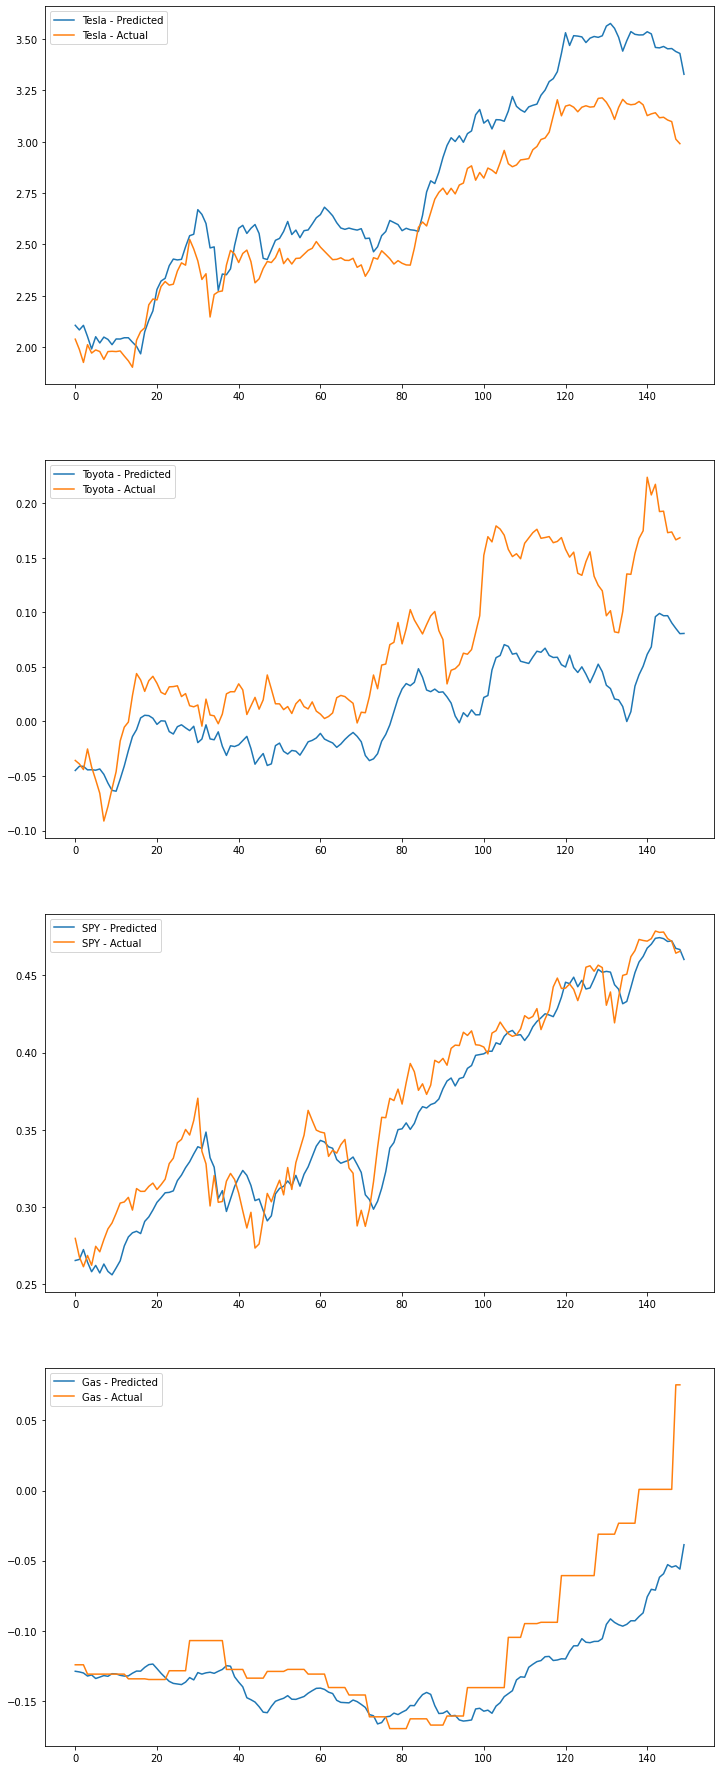

In [706]:
plt.figure(figsize=(12,32))

plt.subplot(4,1,1)
plt.plot(pred[:,0], label='Tesla - Predicted')
plt.plot(y_test[1:,0], label='Tesla - Actual')
plt.legend()

plt.subplot(4,1,2)
plt.plot(pred[:,1], label='Toyota - Predicted')
plt.plot(y_test[1:,1], label='Toyota - Actual')
plt.legend()

plt.subplot(4,1,3)
plt.plot(pred[:,2], label='SPY - Predicted')
plt.plot(y_test[1:,2], label='SPY - Actual')
plt.legend()

plt.subplot(4,1,4)
plt.plot(pred[:,3], label='Gas - Predicted')
plt.plot(y_test[1:,3], label='Gas - Actual')
plt.legend();

Some of those predictions did better than others. Let's now put the predictions back in the original scale.

In [694]:
pred_price = pred[1:,:] - pred[:-1,:].copy()
pred_price = pred_price*price_array[:-1,:]

In [697]:
pred_price = pred_price + price_array[:-1]

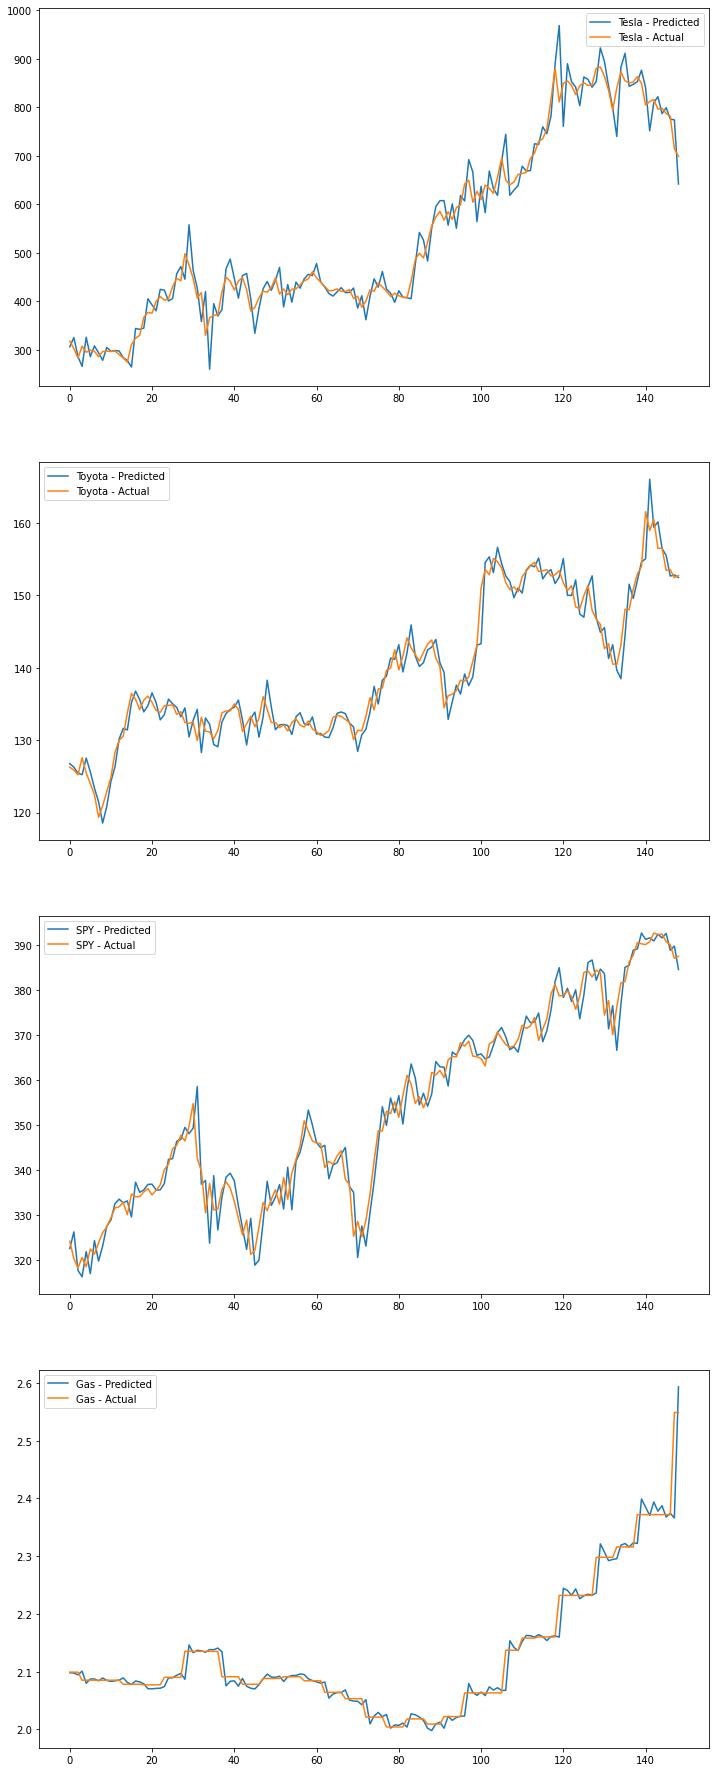

In [702]:
plt.figure(figsize=(12,32))

plt.subplot(4,1,1)
plt.plot(pred_price[:,0], label='Tesla - Predicted')
plt.plot(price_array[1:,0], label='Tesla - Actual')
plt.legend()

plt.subplot(4,1,2)
plt.plot(pred_price[:,1], label='Toyota - Predicted')
plt.plot(price_array[1:,1], label='Toyota - Actual')
plt.legend()

plt.subplot(4,1,3)
plt.plot(pred_price[:,2], label='SPY - Predicted')
plt.plot(price_array[1:,2], label='SPY - Actual')
plt.legend()

plt.subplot(4,1,4)
plt.plot(pred_price[:,3], label='Gas - Predicted')
plt.plot(price_array[1:,3], label='Gas - Actual')
plt.legend();

These predictions look pretty good...!!